# Read and plot DTS data
This notebook shows how to read DTS data from a .csv file and plot it.

In [1]:
# load packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import random
import scipy
from scipy.integrate import odeint
from scipy.integrate import ode, complex_ode
from scipy.optimize import minimize
from findiff import FinDiff
import matplotlib.pyplot as plt
from time import perf_counter
from skimage import feature
from tqdm import tqdm
from skimage.filters import meijering, sato, frangi, hessian
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from symfit import parameters, variables, sin, cos, Fit
import pickle
import math
from scipy.interpolate import UnivariateSpline
from PyAstronomy import pyaC
import get_temp_amplitude
import lmfit
from tg_solver import tg_solve
import pysindy as ps
from pysindy.feature_library import PolynomialLibrary
from pysindy.optimizers import STLSQ
from pysindy.feature_library import CustomLibrary

# import cv2

# matplotlib.use('TkAgg')
%matplotlib widget

# Set up data

In [2]:
# Read temperature data
infile = '../data/DTS/temp_cal_valid_cable_rmnoise.csv'
df_temp = pd.read_csv(infile, index_col=0)
df_temp.columns = pd.to_datetime(df_temp.columns)
df_temp.head()

,2023-08-09 17:09:32.415,2023-08-09 17:14:32.521,2023-08-09 17:19:32.622,2023-08-09 17:24:32.751,2023-08-09 17:29:32.871,2023-08-09 17:34:33.023,2023-08-09 17:39:33.151,2023-08-09 17:44:33.281,2023-08-09 17:49:33.393,2023-08-09 17:54:33.510,...,2023-08-29 13:21:53.278,2023-08-29 13:26:53.872,2023-08-29 13:31:54.456,2023-08-29 13:36:55.019,2023-08-29 13:41:55.583,2023-08-29 13:46:56.141,2023-08-29 13:51:56.718,2023-08-29 13:56:57.291,2023-08-29 14:01:57.900,2023-08-29 14:02:08.202
-22.999,21.8724,21.9242,21.7593,22.0574,22.2256,22.5217,22.7067,22.8808,23.2244,23.5173,...,25.5453,25.3991,25.4547,25.4546,25.6803,25.7883,25.9772,25.8514,25.8928,26.1549
-22.745,21.8849,21.9424,21.7415,22.0645,22.2294,22.5077,22.7098,22.8978,23.2494,23.5068,...,25.5339,25.4029,25.4845,25.4733,25.6727,25.8092,25.9818,25.8577,25.9044,26.1569
-22.490,21.8829,21.9581,21.7719,22.0786,22.2661,22.4844,22.7420,22.8877,23.2459,23.5008,...,25.5144,25.4283,25.4984,25.5012,25.6936,25.8112,25.9707,25.8581,25.9104,26.0933
-22.236,21.9095,21.9571,21.7812,22.0970,22.2612,22.4886,22.7592,22.8818,23.2265,23.4932,...,25.5312,25.4563,25.5038,25.5070,25.7078,25.7885,25.9619,25.8641,25.9341,26.1819
-21.982,21.9441,21.9227,21.7831,22.0871,22.2620,22.5016,22.7392,22.8826,23.2373,23.5235,...,25.5722,25.4460,25.5155,25.5173,25.7258,25.8020,25.9593,25.8840,25.9210,26.2319


In [3]:
df = pd.read_csv(infile, index_col=0)

In [4]:
# Put temperature data, optical distances and sampling times into numpy arrays
temp_arr = df_temp.to_numpy().T # we want to have the time to be in the 0-axis to be consistent with DAS data
times = pd.to_datetime(df_temp.columns)
dists = df_temp.index.to_numpy()

In [5]:
# plot selected DTS data over time
# enter water at: 560m, exit water at 7565m
start_dist = 2820 # east ridge at 2820m optical distance
end_dist = 3150 # seafloor from ~3150m optical distance onward

start_time = times[0] #datetime.datetime(2023,8,9)
end_time = times[-1] #datetime.datetime(2023,8,30)

t_idx_start = 0 # np.argmin(np.abs(times-start_time))
t_idx_end = -1 # np.argmin(np.abs(times-end_time))
d_idx_start = 0 # np.argmin(np.abs(dists-start_dist))
d_idx_end = -1 # np.argmin(np.abs(dists-end_dist))

plot_arr = temp_arr[t_idx_start:t_idx_end, d_idx_start:d_idx_end]
plot_times = times[t_idx_start:t_idx_end]
plot_dists = dists[d_idx_start:d_idx_end]


In [6]:
# filter = scipy.signal.butter(1, 0.0111, 'hp', fs=5, output='sos', analog=False) # 5 represents 5 second sampling rate
# Band pass filter 

startt = datetime.datetime(2023, 8, 25, 16) # 25
endt = datetime.datetime(2023, 8, 25, 18) # 25

# plt.ylim([11000,16500])
# plt.xlim([4620,4680])
startind_t = 4620# np.absolute(plot_times - startt).argmin()
endind_t = 4680# np.absolute(plot_times - endt).argmin()

# startind_d = np.absolute(plot_dists - 2940).argmin()
# endind_d = np.absolute(plot_dists - 3000).argmin()

startind_d = 11000 # np.absolute(plot_dists - 2900).argmin()
endind_d = 12500 # np.absolute(plot_dists - 3300).argmin()

filtered_arr = scipy.ndimage.gaussian_filter(plot_arr[startind_t:endind_t, startind_d:endind_d], 5, axes=1)
filtered_arr = scipy.ndimage.gaussian_filter(filtered_arr, 0)
plot_times_zoomed = plot_times[startind_t:endind_t]
plot_times_zoomed_int = plot_times_zoomed.astype('int64')
plot_dists_zoomed = plot_dists[startind_d:endind_d]

## Contour

In [7]:
contour_arr = np.empty(len(plot_times_zoomed))

cv = 0.6
for i in range(len(filtered_arr[:, 0])):
    xc = pyaC.zerocross1d(plot_dists_zoomed, filtered_arr[i, :] - cv)
    # print(len(xc))
    if(len(xc) == 1):
        contour_arr[i] = xc.flatten().tolist()[0]
    else:
        contour_arr[i] = xc.flatten().tolist()[0]

## Temperature plotted data and slice of disps

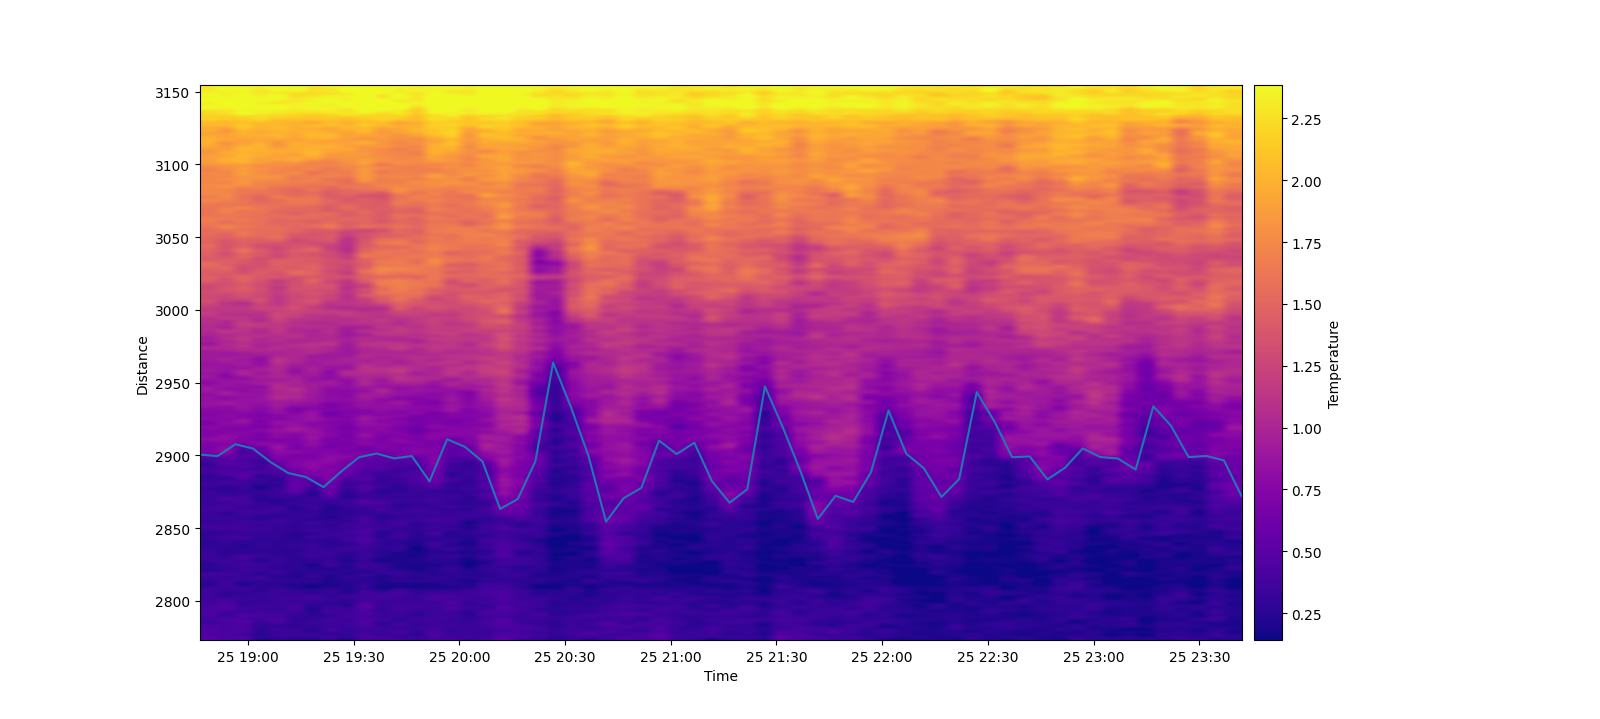

In [8]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
# filtered_arr[filtered_arr > 1] = 'NaN'
im1 = ax.imshow(filtered_arr.T, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(filtered_arr[~np.isnan(filtered_arr)],1),
            vmax=np.percentile(filtered_arr[~np.isnan(filtered_arr)],99),
            )
plt.plot(plot_times_zoomed, contour_arr, '-')
# for i in range(len(contour_values)): plt.plot(contour_points[contour_values[i]]['t'], contour_points[contour_values[i]]['x'], '.')
# plt.contour(plot_times_zoomed, plot_dists_zoomed, filtered_arr.T, contour_values)

ax.set_ylabel('Distance')
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Temperature')
plt.show()

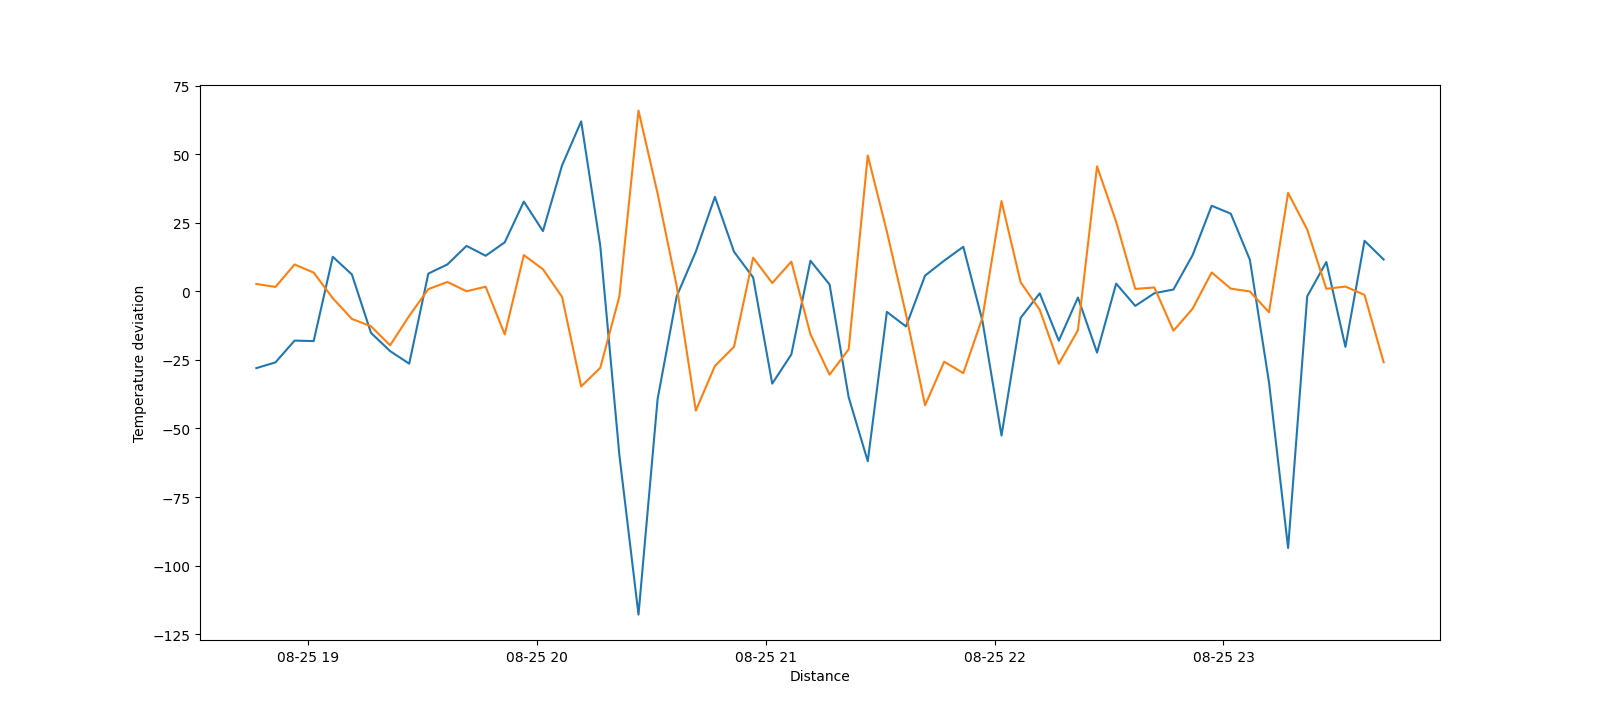

In [9]:
avg_filtered_arr = np.nanmedian(filtered_arr, axis=1)
contour_arr = contour_arr - np.median(contour_arr)

# filter = scipy.signal.butter(1, 0.1, 'hp', fs=5, output='sos', analog=False) # 5 represents 5 second sampling rate
# high_pass_filtered_arr = scipy.signal.sosfilt(filter, avg_filtered_arr - np.median(avg_filtered_arr))

fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
ax.plot(plot_times_zoomed, (avg_filtered_arr - np.median(avg_filtered_arr))*300) # Mean over the cable length over time
ax.plot(plot_times_zoomed, contour_arr) # Contour shown above plotted
# ax.plot(plot_times_zoomed, high_pass_filtered_arr)
ax.set_xlabel('Distance')
ax.set_ylabel('Temperature deviation')
plt.show()

# Set up SINDy

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps
# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

## Actual SINDy Stuff

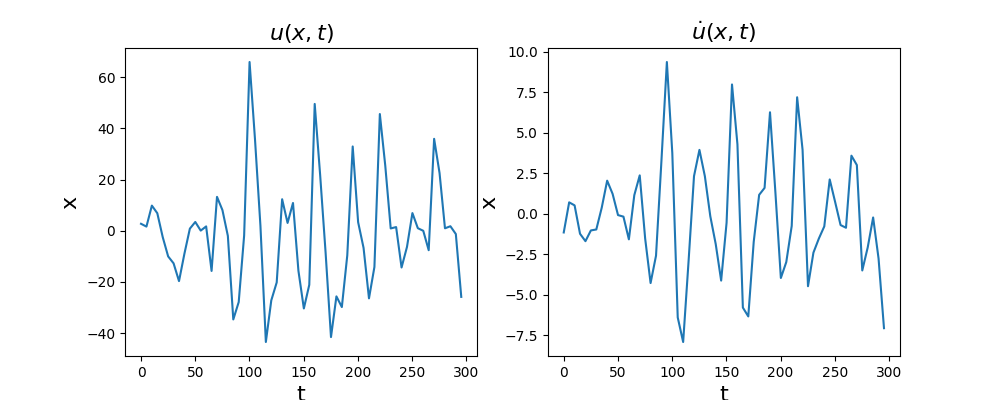

In [11]:
# Example data (replace with your actual data)
train_ind = -1
t = np.array(plot_times_zoomed_int - plot_times_zoomed_int[0]) * 1.666e-11 # grid_x[:, 0]
dt = t[1] - t[0]

u_sol = contour_arr
v_sol = ps.FiniteDifference(axis=0)._differentiate(contour_arr, t=dt)


u = np.zeros((len(t), 2))
u[:, 0] = u_sol
u[:, 1] = v_sol
u_dot = ps.FiniteDifference(axis=0)._differentiate(u, t=dt)

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t, u[:, 0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)

plt.subplot(1, 2, 2)
plt.plot(t, u_dot[:, 0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

In [12]:
train = range(0, int(len(t) * 0.7))
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[train, :]
u_test = u[test, :]
u_dot_train = u_dot[train, :]
u_dot_test = u_dot[test, :]
t_train = t[train]
t_test = t[test]

feature_library = ps.PolynomialLibrary(degree=3)
optimizer = ps.STLSQ(threshold=0.02)
differentiation_method = ps.FiniteDifference(order=3)

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["u", "du/dt"],
)
model.fit(u_train, t=t_train, ensemble=True, n_models=100, quiet=True)
model.print()

(u)' = -0.009 1 + -0.042 u + 1.174 du/dt
(du/dt)' = -0.082 1 + -0.031 u + -0.031 du/dt


In [13]:
mean_ensemble = np.mean(model.coef_list, axis=0)
std_ensemble = np.std(model.coef_list, axis=0)

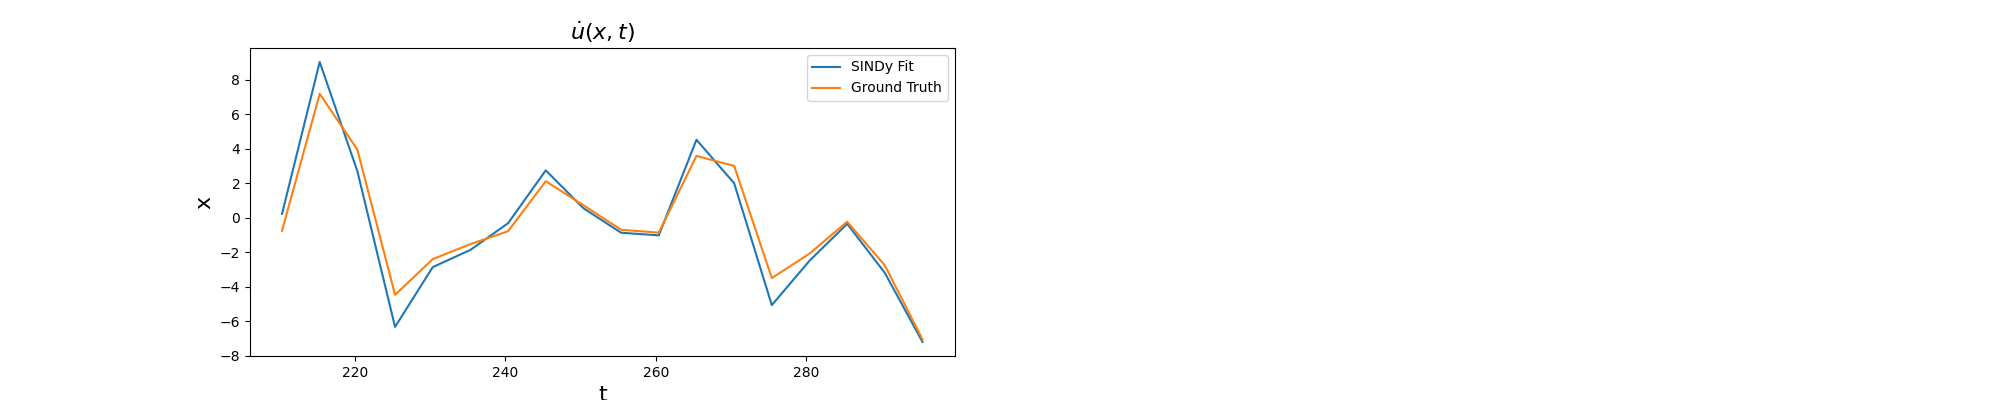

In [14]:
x1 = u_test[0, 1]
x0 = u_test[0, 0]
pred = model.predict(u_test)
# sim = model.simulate([x0, x1], t=t_test)

plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(t_test, pred[:, 0])
plt.plot(t_test, u_dot_test[:, 0])
# plt.plot(t_train, sim[:, 0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.legend(["SINDy Fit", "Ground Truth"])